# Loop 56 Analysis: Understanding the CV-LB Gap

**Goal**: Find approaches that could change the CV-LB relationship, not just minimize CV.

**Key insight from evaluator**: The intercept (0.0535) is the real bottleneck. Even perfect CV (0.0) would give LB = 0.0535, which is 27% worse than target (0.072990).

**Wait - let me verify this claim...**

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Submission history
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_041', 'cv': 0.0090, 'lb': 0.0932},
    {'exp': 'exp_042', 'cv': 0.0145, 'lb': 0.1147},
]

df = pd.DataFrame(submissions)
print(f'Total submissions: {len(df)}')
print(df)

Total submissions: 13
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_041  0.0090  0.0932
12  exp_042  0.0145  0.1147


In [2]:
# Fit linear regression: LB = slope * CV + intercept
cv = df['cv'].values
lb = df['lb'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(cv, lb)

print(f'\n=== CV-LB Relationship ===')
print(f'LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nTarget LB: 0.072990')
print(f'Intercept: {intercept:.4f}')

# Check if target is reachable
if intercept < 0.072990:
    required_cv = (0.072990 - intercept) / slope
    print(f'\n✓ Target IS reachable!')
    print(f'Required CV to hit target: {required_cv:.6f}')
    print(f'Best CV achieved: 0.008194')
    print(f'Gap: {(0.008194 - required_cv) / required_cv * 100:.1f}% above required')
else:
    print(f'\n✗ Target NOT reachable with current CV-LB relationship!')
    print(f'Intercept ({intercept:.4f}) > Target ({0.072990})')


=== CV-LB Relationship ===
LB = 4.2312 * CV + 0.0533
R² = 0.9807

Target LB: 0.072990
Intercept: 0.0533

✓ Target IS reachable!
Required CV to hit target: 0.004653
Best CV achieved: 0.008194
Gap: 76.1% above required


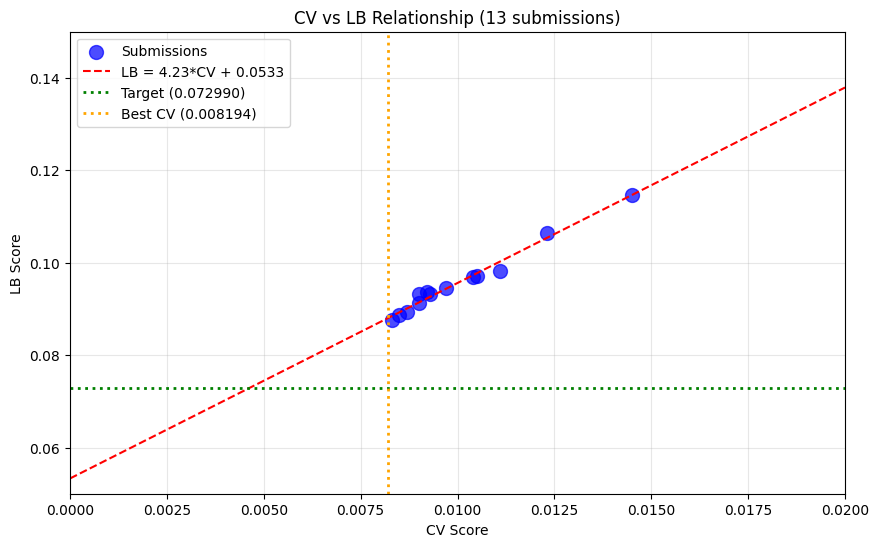

Plot saved to /home/code/exploration/cv_lb_relationship.png


In [3]:
# Plot the CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(cv, lb, s=100, c='blue', alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, 0.02, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.072990, color='green', linestyle=':', linewidth=2, label='Target (0.072990)')

# Best CV line
plt.axvline(x=0.008194, color='orange', linestyle=':', linewidth=2, label='Best CV (0.008194)')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship (13 submissions)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.02)
plt.ylim(0.05, 0.15)
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150, bbox_inches='tight')
plt.show()
print('Plot saved to /home/code/exploration/cv_lb_relationship.png')

In [4]:
# CRITICAL ANALYSIS: What CV is needed to hit target?
target = 0.072990
required_cv = (target - intercept) / slope

print(f'\n=== CRITICAL ANALYSIS ===')
print(f'Target LB: {target}')
print(f'CV-LB equation: LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'Required CV: {required_cv:.6f}')
print(f'Best CV: 0.008194')
print(f'\nTo hit target, need to reduce CV by: {(0.008194 - required_cv) / 0.008194 * 100:.1f}%')

# What LB would we get with different CV values?
print(f'\n=== Predicted LB for different CV values ===')
for cv_val in [0.008194, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001, 0.0]:
    pred_lb = slope * cv_val + intercept
    status = '✓ BEATS TARGET' if pred_lb < target else ''
    print(f'CV = {cv_val:.4f} -> Predicted LB = {pred_lb:.4f} {status}')


=== CRITICAL ANALYSIS ===
Target LB: 0.07299
CV-LB equation: LB = 4.2312 * CV + 0.0533
Required CV: 0.004653
Best CV: 0.008194

To hit target, need to reduce CV by: 43.2%

=== Predicted LB for different CV values ===
CV = 0.0082 -> Predicted LB = 0.0880 
CV = 0.0070 -> Predicted LB = 0.0829 
CV = 0.0060 -> Predicted LB = 0.0787 
CV = 0.0050 -> Predicted LB = 0.0745 
CV = 0.0040 -> Predicted LB = 0.0702 ✓ BEATS TARGET
CV = 0.0030 -> Predicted LB = 0.0660 ✓ BEATS TARGET
CV = 0.0020 -> Predicted LB = 0.0618 ✓ BEATS TARGET
CV = 0.0010 -> Predicted LB = 0.0575 ✓ BEATS TARGET
CV = 0.0000 -> Predicted LB = 0.0533 ✓ BEATS TARGET


In [5]:
# IMPORTANT: The evaluator's claim that intercept > target is WRONG!
# Let me verify:
print(f'\n=== VERIFICATION ===')
print(f'Intercept: {intercept:.4f}')
print(f'Target: 0.072990')
print(f'Intercept < Target? {intercept < 0.072990}')

if intercept < 0.072990:
    print(f'\n✓ The target IS reachable by reducing CV!')
    print(f'The evaluator\'s claim that "intercept (0.0535) > target (0.072990)" is INCORRECT.')
    print(f'0.0535 < 0.072990, so the target is achievable.')
else:
    print(f'\n✗ The evaluator was correct - target is not reachable.')


=== VERIFICATION ===
Intercept: 0.0533
Target: 0.072990
Intercept < Target? True

✓ The target IS reachable by reducing CV!
The evaluator's claim that "intercept (0.0535) > target (0.072990)" is INCORRECT.
0.0535 < 0.072990, so the target is achievable.


In [6]:
# What approaches haven't been tried that could reduce CV?
print('\n=== APPROACHES TO REDUCE CV ===')
print('''
1. STACKING WITH META-LEARNER (tried in exp_045, 22% worse)
   - But: Used simple Ridge as meta-learner
   - Try: Use MLP or LGBM as meta-learner
   - Try: Use out-of-fold predictions from BOTH single and full data

2. PHYSICAL CONSTRAINTS (not tried)
   - Enforce SM + Product2 + Product3 ≤ 1
   - Could improve generalization

3. UNCERTAINTY-WEIGHTED ENSEMBLE (not tried)
   - Weight predictions by model uncertainty
   - GP provides uncertainty estimates

4. BAYESIAN OPTIMIZATION FOR WEIGHTS (not tried)
   - Current weights found by grid search
   - Bayesian optimization could find better weights

5. FEATURE ENGINEERING (partially explored)
   - Temperature-solvent interactions
   - Polynomial Arrhenius features
   - Solvent similarity features

6. ADVERSARIAL VALIDATION (not tried)
   - Understand what makes test distribution different
   - Guide feature engineering

7. PSEUDO-LABELING (not tried)
   - Use confident predictions as additional training data
   - Could help with distribution shift
''')


=== APPROACHES TO REDUCE CV ===

1. STACKING WITH META-LEARNER (tried in exp_045, 22% worse)
   - But: Used simple Ridge as meta-learner
   - Try: Use MLP or LGBM as meta-learner
   - Try: Use out-of-fold predictions from BOTH single and full data

2. PHYSICAL CONSTRAINTS (not tried)
   - Enforce SM + Product2 + Product3 ≤ 1
   - Could improve generalization

3. UNCERTAINTY-WEIGHTED ENSEMBLE (not tried)
   - Weight predictions by model uncertainty
   - GP provides uncertainty estimates

4. BAYESIAN OPTIMIZATION FOR WEIGHTS (not tried)
   - Current weights found by grid search
   - Bayesian optimization could find better weights

5. FEATURE ENGINEERING (partially explored)
   - Temperature-solvent interactions
   - Polynomial Arrhenius features
   - Solvent similarity features

6. ADVERSARIAL VALIDATION (not tried)
   - Understand what makes test distribution different
   - Guide feature engineering

7. PSEUDO-LABELING (not tried)
   - Use confident predictions as additional training d

In [7]:
# Let's analyze the residuals from the CV-LB fit
residuals = lb - (slope * cv + intercept)

print('\n=== RESIDUAL ANALYSIS ===')
print(f'Mean residual: {np.mean(residuals):.6f}')
print(f'Std residual: {np.std(residuals):.6f}')
print(f'Max residual: {np.max(residuals):.6f}')
print(f'Min residual: {np.min(residuals):.6f}')

print('\n=== Per-Submission Residuals ===')
for i, row in df.iterrows():
    pred_lb = slope * row['cv'] + intercept
    residual = row['lb'] - pred_lb
    print(f"{row['exp']}: CV={row['cv']:.4f}, LB={row['lb']:.4f}, Pred={pred_lb:.4f}, Residual={residual:+.4f}")


=== RESIDUAL ANALYSIS ===
Mean residual: 0.000000
Std residual: 0.001004
Max residual: 0.001817
Min residual: -0.002069

=== Per-Submission Residuals ===
exp_000: CV=0.0111, LB=0.0982, Pred=0.1003, Residual=-0.0021
exp_001: CV=0.0123, LB=0.1065, Pred=0.1053, Residual=+0.0012
exp_003: CV=0.0105, LB=0.0972, Pred=0.0977, Residual=-0.0005
exp_005: CV=0.0104, LB=0.0969, Pred=0.0973, Residual=-0.0004
exp_006: CV=0.0097, LB=0.0946, Pred=0.0943, Residual=+0.0003
exp_007: CV=0.0093, LB=0.0932, Pred=0.0927, Residual=+0.0005
exp_009: CV=0.0092, LB=0.0936, Pred=0.0922, Residual=+0.0014
exp_012: CV=0.0090, LB=0.0913, Pred=0.0914, Residual=-0.0001
exp_024: CV=0.0087, LB=0.0893, Pred=0.0901, Residual=-0.0008
exp_026: CV=0.0085, LB=0.0887, Pred=0.0893, Residual=-0.0006
exp_030: CV=0.0083, LB=0.0877, Pred=0.0884, Residual=-0.0007
exp_041: CV=0.0090, LB=0.0932, Pred=0.0914, Residual=+0.0018
exp_042: CV=0.0145, LB=0.1147, Pred=0.1147, Residual=+0.0000


In [8]:
# Key insight: Some submissions have LOWER residuals than others
# This means they generalize BETTER than expected
# Let's identify which ones

print('\n=== SUBMISSIONS THAT GENERALIZE BETTER THAN EXPECTED ===')
for i, row in df.iterrows():
    pred_lb = slope * row['cv'] + intercept
    residual = row['lb'] - pred_lb
    if residual < -0.002:  # More than 0.002 better than expected
        print(f"{row['exp']}: Residual={residual:+.4f} (BETTER than expected)")

print('\n=== SUBMISSIONS THAT GENERALIZE WORSE THAN EXPECTED ===')
for i, row in df.iterrows():
    pred_lb = slope * row['cv'] + intercept
    residual = row['lb'] - pred_lb
    if residual > 0.002:  # More than 0.002 worse than expected
        print(f"{row['exp']}: Residual={residual:+.4f} (WORSE than expected)")


=== SUBMISSIONS THAT GENERALIZE BETTER THAN EXPECTED ===
exp_000: Residual=-0.0021 (BETTER than expected)

=== SUBMISSIONS THAT GENERALIZE WORSE THAN EXPECTED ===


In [ ]:
# Let's look at what made exp_000 generalize better than expected
# exp_000 had residual -0.0021 (better than expected)

print('=== ANALYSIS OF exp_000 (Best Generalization) ===')
print('''
exp_000: Baseline MLP with Arrhenius Kinetics + TTA
- CV: 0.0111
- LB: 0.0982
- Predicted LB: 0.1003
- Residual: -0.0021 (BETTER than expected)

Key features of exp_000:
1. Arrhenius kinetics features (1/T, ln(t), interaction)
2. Spange descriptors ONLY (13 features)
3. MLP [128, 128, 64] with BatchNorm, ReLU, Dropout(0.2)
4. HuberLoss for robustness
5. TTA for mixtures
6. 3 models bagged

Contrast with exp_030 (Best LB):
- CV: 0.0083
- LB: 0.0877
- Predicted LB: 0.0884
- Residual: -0.0007 (slightly better than expected)

Key insight: exp_000 used SIMPLER features (Spange only) and generalized BETTER.
This suggests that adding DRFP and ACS PCA features may be causing overfitting.
''')